In [2]:
# notebook for unsupervised segmentation based on the paper: 
#  Unsupervised Learning of Image Segmentation Based on Differentiable Feature Clustering.
# Wonjik Kim*, Asako Kanezaki*, and Masayuki Tanaka

from pathlib import Path
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.io import read_image
import numpy as np
import matplotlib.pyplot as plt
import os
import argparse
%matplotlib inline


In [18]:
# paths
cwd = Path.cwd()
print(cwd)
path_data = cwd.parent/"dataset/ref/"
path_valid = cwd.parent/"dataset/valid/"
#for f in path_valid.iterdir():
#    print(f.name)

/media/ben/Data_linux/code/unsupervised_learning/notebooks


In [25]:
# parameters
SIZE = (128*1, 128*1)
BS = 4
nChannel = 40
nConv = 2
LR = 0.05
EPOCHS = 80
SANITY_CHECK = False
STEPSIZE_CON = 5                      # weight for the continuity loss
STEPSIZE_SIM = 1                      # weight for the similarity loss
SAVE_MODEL = False
WRITE_PICS = True
PLOT = False
MIN_LABELS = 5
TRAIN = True
INFERENCE = False

In [23]:
list_images = [im.as_posix() for im in path_data.iterdir()]
valid_images = [im.as_posix() for im in path_valid.iterdir()]
print(f"list_im:{len(list_images)}, val_im:{len(valid_images)}")

list_im:40, val_im:20


In [24]:
 # device
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

In [26]:
# DatasetClass
class ImageDataset:
    def __init__(self, image_paths, size=SIZE):
        self.image_paths = image_paths
        self.size = size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, item):
        image = cv2.imread(self.image_paths[item])
        resized_im = cv2.resize(image, dsize=self.size)
        resized_im = resized_im.transpose( (2, 0, 1) ).astype('float32')/255.
        image_tensor = torch.tensor(resized_im)
        return image_tensor

def make_dataset_dataloader():
    
    # datasets and dataloaders
    ds_train = ImageDataset(image_paths=list_images)
    ds_valid = ImageDataset(image_paths=valid_images)
    print(f"len(ds_train):{len(ds_train)}, len(ds_valid):{len(ds_valid)}")
    # 2. make dataloaders
    train_dl = torch.utils.data.DataLoader(dataset=ds_train,batch_size=BS, shuffle=True)
    valid_dl = torch.utils.data.DataLoader(dataset=ds_valid, batch_size=BS, shuffle=False)
    print(f"len(train_dl):{len(train_dl)}, len(valid_dl):{len(valid_dl)}")
    
    return train_dl, valid_dl, ds_train, ds_valid
train_dl, valid_dl, ds_train, ds_valid = make_dataset_dataloader()

len(ds_train):40, len(ds_valid):20
len(train_dl):10, len(valid_dl):5


In [27]:
# define a cnn  model
class MyNet(nn.Module):
    def __init__(self,input_dim):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(input_dim, nChannel, kernel_size=3, stride=1, padding=1 )
        self.bn1 = nn.BatchNorm2d(nChannel)
        self.conv2 = nn.ModuleList()
        self.bn2 = nn.ModuleList()
        for i in range(nConv-1):
            self.conv2.append( nn.Conv2d(nChannel, nChannel, kernel_size=3, stride=1, padding=1 ) )
            self.bn2.append( nn.BatchNorm2d(nChannel) )
        self.conv3 = nn.Conv2d(nChannel, nChannel, kernel_size=1, stride=1, padding=0 )
        self.bn3 = nn.BatchNorm2d(nChannel)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu( x )
        x = self.bn1(x)
        for i in range(nConv-1):
            x = self.conv2[i](x)
            x = F.relu( x )
            x = self.bn2[i](x)
        x = self.conv3(x)
        x = self.bn3(x)
        return x

M1 = MyNet(input_dim=3).to(device)

In [28]:
for item in train_dl:
    x = item
    break
print(f"x.size:{x.size()}")
# 4. loss function, and colors
# similarity loss definition
loss_fn = torch.nn.CrossEntropyLoss()

# continuity loss definition
loss_hpy = torch.nn.L1Loss(reduction='mean')
loss_hpz = torch.nn.L1Loss(reduction='mean')
optimizer = torch.optim.SGD(M1.parameters(), lr=LR, momentum=0.9)
label_colours = np.random.randint(255, size=(100, 3))

# 5. training loop
HPy_target = torch.zeros(x.shape[0], x.shape[2]-1, x.shape[3], nChannel)
HPz_target = torch.zeros(x.shape[0], x.shape[2], x.shape[3]-1, nChannel)

HPy_target = HPy_target.to(device)
HPz_target = HPz_target.to(device)

print(f"HPY:{HPy_target.shape}")
print(f"HPz:{HPz_target.shape}")

x.size:torch.Size([4, 3, 128, 128])
HPY:torch.Size([4, 127, 128, 40])
HPz:torch.Size([4, 128, 127, 40])


In [29]:
stepsize_con = STEPSIZE_CON
stepsize_sim = STEPSIZE_SIM
def loss_one_epoch(model=M1, dataloader=train_dl, sanity_check=SANITY_CHECK, lr=LR, save_model=SAVE_MODEL):
    """ training one epoch"""

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    running_loss  = 0.0
    bool_minlabel = False
    for image in dataloader:
        image = image.to(device)
        optimizer.zero_grad()
        output = model(image)
        output = output.permute( 0, 2, 3, 1 ).contiguous().view(BS, -1, nChannel)
        outputHP = output.reshape((BS, image.shape[2], image.shape[3], nChannel))
        HPy = outputHP[:, 1:, :, :] - outputHP[:, 0:-1, :, :]
        HPz = outputHP[:, :, 1:, :] - outputHP[:, :, 0:-1, :]

        lhpy = loss_hpy(HPy, HPy_target)
        lhpz = loss_hpz(HPz, HPz_target)

        output = output.reshape(output.shape[0] * output.shape[1], -1 )
        ignore, target = torch.max(output, 1 )
        nLabels = len(torch.unique(target))
        #print(f"nlabels:{nLabels}")
        loss = stepsize_sim * loss_fn(output, target) + stepsize_con * (lhpy + lhpz)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if sanity_check:
            break

        if nLabels <= MIN_LABELS:
            print ("nLabels", nLabels, "reached minLabels", MIN_LABELS, ".")
            bool_minlabel = True
            break

    #if save_model:
    #    torch.save(model.state_dict(), './models/model.pth')
    return running_loss / len(dataloader), bool_minlabel

In [24]:
cwd.parent/'models'

PosixPath('/media/ben/Data_linux/code/unsupervised_learning/models')

In [30]:
def training_loop(epochs=EPOCHS):
    """ function to train the model"""
    loss_history = []
    for epoch in range(EPOCHS):
        M1.train()
        loss_epoch, min_label_reached = loss_one_epoch(model=M1,
                                                       dataloader=train_dl,
                                                       sanity_check=SANITY_CHECK,
                                                       lr=LR)
        loss_history.append(loss_epoch)
        print(f"epoch:{epoch}, loss:{loss_epoch}")
        if min_label_reached:
            print("minimum labels reached")
            break
    return M1, loss_history

if TRAIN:                                                      # training
    M1, loss_history = training_loop(epochs=EPOCHS)
else:                                                          # loading a train model
    M1 =  MyNet(input_dim=3).to(device)
    M1.load_state_dict(torch.load(cwd.parent/"models/model_batch.pth"))
    M1.eval()
if SAVE_MODEL:
    torch.save(M1.state_dict(), cwd.parent/f"models/model_batch_{SIZE[0]}.pth")

epoch:0, loss:3.109053349494934
epoch:1, loss:2.138093554973602
epoch:2, loss:1.5795988082885741
epoch:3, loss:1.3229715466499328
epoch:4, loss:1.0731671392917632
epoch:5, loss:0.9632143378257751
epoch:6, loss:0.8312647581100464
epoch:7, loss:0.7951816082000732
epoch:8, loss:0.8193623721599579
epoch:9, loss:0.7074422597885132
epoch:10, loss:0.7063643276691437
epoch:11, loss:0.7396718740463257
epoch:12, loss:0.6489037156105042
epoch:13, loss:0.5637289106845855
epoch:14, loss:0.5538885831832886
epoch:15, loss:0.5108263045549393
epoch:16, loss:0.5551586389541626
epoch:17, loss:0.5864290118217468
epoch:18, loss:0.5633482694625854
epoch:19, loss:0.4890734314918518
epoch:20, loss:0.4245392829179764
epoch:21, loss:0.445762500166893
epoch:22, loss:0.4327726006507874
epoch:23, loss:0.45799010097980497
epoch:24, loss:0.4075427532196045
nLabels 5 reached minLabels 5 .
epoch:25, loss:0.47179773151874543
minimum labels reached


In [31]:
# training loss
if PLOT:
    list_epochs = range(len(loss_history))
    plt.plot(list_epochs, loss_history)
    plt.xlabel("epochs")
    plt.ylabel("loss")
    #plt.legend()
    plt.show()

In [56]:
if SAVE_MODEL:
    torch.save(M1.state_dict(), cwd.parent/f"models/model_batch_{SIZE[0]}.pth")

In [32]:
def inference(data_loader=valid_dl):
    """ function for inference"""
    list_im = []
    for bn, img in enumerate(data_loader):
        M1.eval()
        img = img.to(device)
        output = M1(img)
        output = output.permute(0, 2, 3, 1).view(BS,-1, nChannel)
        ignore, target = torch.max( output, 2 )
        inds = target.data.cpu().numpy().reshape( (BS, img.shape[2], img.shape[3]) )
        inds_rgb = np.array([label_colours[ c % nChannel ] for c in inds])
        inds_rgb = inds_rgb.reshape( img.shape ).astype( np.uint8 )

        print(f"batch number:{bn}")
        if WRITE_PICS:
            
            len_valid = len(valid_dl)
            iter_list = list(path_valid.iterdir())
            for i in range(BS):
                filename = iter_list[bn*BS + i].name
                output_im = inds_rgb[i,:,:,:]
                output_im2 = np.reshape(output_im, (*SIZE,3))
                list_im.append(output_im2)
                #cv2.imwrite(file_path_saved + f"image_bn_{bn}_im{i}.png", output_im2)
                cv2.imwrite(file_path_saved + f"{filename}", output_im2)
                
    return list_im

In [33]:
# folder to save the results, inference
file_path_saved = f"/media/ben/Data_linux/code/unsupervised_learning/dataset/new_test2/new_dat_epochs_{EPOCHS}_image_step_con_{STEPSIZE_CON}_step_sim_{STEPSIZE_SIM}_size_{SIZE[0]}_nconv_{nConv}/"
if not os.path.exists(file_path_saved):
    os.mkdir(file_path_saved)
print(file_path_saved)

/media/ben/Data_linux/code/unsupervised_learning/dataset/new_test2/new_dat_epochs_80_image_step_con_5_step_sim_1_size_128_nconv_2/


In [34]:
list_im = inference()

batch number:0
batch number:1
batch number:2
batch number:3
batch number:4


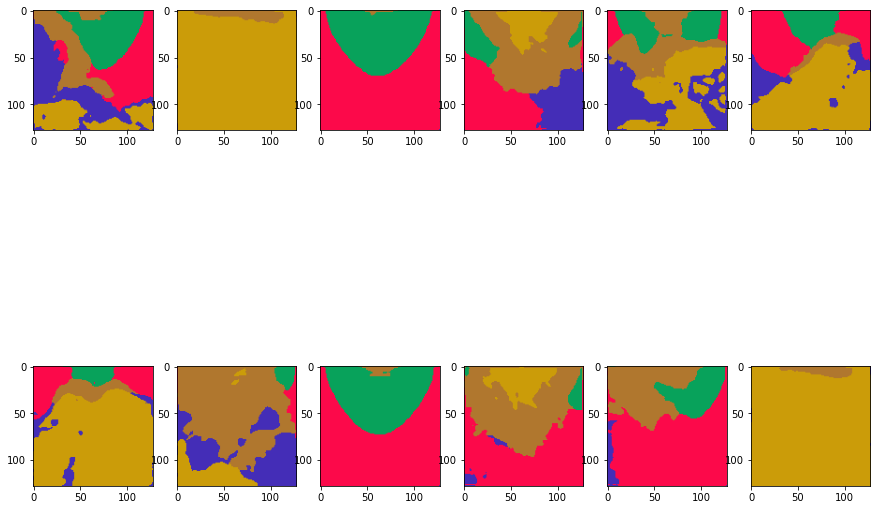

In [36]:
def make_plot(list1=list_im):
    """ function to plot segmented images"""
    fig, ax = plt.subplots(2, 6, figsize=(15,12))
    row = 0
    col = 0
    for i in range(12):
        ax[row, col].imshow(list_im[i])
        #ax[row, col].set_title(f"plot ({row}, {col})")
        col +=1
        if col > 5:
            row +=1
            col = 0
make_plot()